In [91]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
#from geopy.distance import geodesic
from pykalman import KalmanFilter
import numpy as np
from scipy import stats

In [92]:
def charger_donnees(nomcsv, nomtel):
    """Charge les données des fichiers CSV."""
    try:
        gps_data = pd.read_csv(f'results/archive/acquisitionsGPS/{nomcsv}.csv')
        tel_data = pd.read_csv(f'results/archive/acquisitionsTELEPHONE/CSV/{nomtel}.csv')
        return gps_data, tel_data
    except FileNotFoundError as e:
        print(f"Erreur : fichier non trouvé - {e}")
    except pd.errors.EmptyDataError:
        print("Erreur : un des fichiers CSV est vide.")
    except pd.errors.ParserError:
        print("Erreur : problème de format dans un fichier CSV.")
    return None, None

In [93]:
convert_time = lambda x: datetime.strptime(x, "%Y/%m/%d - %H:%M:%S").strftime("%Y-%m-%dT%H:%M:%SZ")

In [94]:
def fusionner_donnees(gps_data, tel_data):
    """Fusionne les données GPS et téléphone sur la colonne UTC."""
    return pd.merge_asof(
        gps_data.sort_values('UTC'),
        tel_data.sort_values('UTC'),
        on='UTC', suffixes=('_GPS', '_Tel')
    ).dropna()

In [95]:

def haversine_distance(lat1, lon1, lat2, lon2):
    """Calcule la distance haversine entre deux points GPS."""
    return geodesic((lat1, lon1), (lat2, lon2)).meters

In [96]:
def calculer_erreurs(merged_df):
    """Ajoute une colonne de distance et affiche les statistiques d'erreur."""
    merged_df['distance'] = merged_df.apply(lambda row: haversine_distance(
        row['Latitude_GPS'], row['Longitude_GPS'], row['Latitude_Tel'], row['Longitude_Tel']), axis=1)
    print(f"Erreur moyenne : {merged_df['distance'].mean():.2f} mètres")
    print(f"Erreur max : {merged_df['distance'].max():.2f} mètres")
    print(f"Erreur min : {merged_df['distance'].min():.2f} mètres")
    return merged_df


In [97]:
def creer_dossier_sauvegarde(nomresult):
    """Crée un dossier de sauvegarde pour les résultats."""
    output_folder = f'traitements/{nomresult}'
    os.makedirs(output_folder, exist_ok=True)
    return output_folder

In [98]:
def calculer_chemin_moyen(merged_df):
    merged_df['Latitude_corrigée'] = merged_df[['Latitude_GPS', 'Latitude_Tel']].mean(axis=1)
    merged_df['Longitude_corrigée'] = merged_df[['Longitude_GPS', 'Longitude_Tel']].mean(axis=1)

In [99]:
def generer_graphiques(merged_df, output_folder):
    """Génère et sauvegarde différents graphiques de comparaison."""
    plt.figure(figsize=(8, 6))
    plt.scatter(merged_df['Longitude_GPS'], merged_df['Latitude_GPS'], label='GPS', alpha=0.6, marker='x')
    plt.scatter(merged_df['Longitude_Tel'], merged_df['Latitude_Tel'], label='Tel', alpha=0.6, marker='x')
    plt.scatter(merged_df['Longitude_corrigée'], merged_df['Latitude_corrigée'], label='Moyen', alpha=0.6, marker='x')
    plt.legend()
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Comparaison des trajets GPS')
    plt.savefig(f'{output_folder}/comparaison_trajets.png')
    plt.show()

    plt.figure()
    plt.plot(merged_df['distance'], label='Distance GPS - Tel')
    plt.xlabel('Index')
    plt.ylabel('Distance (mètres)')
    plt.title("Évolution de l'erreur")
    plt.legend()
    plt.savefig(f'{output_folder}/erreur_evolution.png')
    plt.show()

    plt.figure()
    plt.plot(merged_df['Latitude_GPS'], label='Latitude GPS')
    plt.plot(merged_df['Latitude_Tel'], label='Latitude Tel')
    plt.legend()
    plt.savefig(f'{output_folder}/comparaison_latitude.png')
    plt.show()

    plt.figure()
    plt.plot(merged_df['Longitude_GPS'], label='Longitude GPS')
    plt.plot(merged_df['Longitude_Tel'], label='Longitude Tel')
    plt.legend()
    plt.savefig(f'{output_folder}/comparaison_longitude.png')
    plt.show()

In [100]:
def sauvegarder_resultats(merged_df, output_folder):
    output_file = f'{output_folder}/results.csv'
    merged_df.to_csv(output_file, index=False)
    print(f"Résultats sauvegardés dans : {output_file}")

In [101]:
def calculer_vitesse_acceleration(df, lat_col='Latitude_GPS', lon_col='Longitude_GPS', time_col='UTC'):
    df = df.copy().sort_values(time_col)

    df['time_diff'] = df[time_col].diff().dt.total_seconds()
    df['lat_diff'] = df[lat_col].diff()
    df['lon_diff'] = df[lon_col].diff()

    df['distance_diff'] = df.apply(
        lambda row: haversine_distance(
            row[lat_col], row[lon_col],
            row[lat_col] - row['lat_diff'],
            row[lon_col] - row['lon_diff']
        ) if not np.isnan(row['lat_diff']) else np.nan,
        axis=1
    )

    df['vitesse'] = df['distance_diff'] / df['time_diff']

    df['acceleration'] = df['vitesse'].diff() / df['time_diff']

    return df

In [102]:
def generer_boxplots(df, output_folder):
    """Génère des boxplots pour la vitesse et l'accélération avec les limites des moustaches."""
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    bp = plt.boxplot(df['vitesse'].dropna(), vert=True, patch_artist=True)
    for flier in bp['fliers']:
        flier.set(marker='o', color='red', alpha=0.5)
    plt.title('Distribution de la vitesse')
    plt.ylabel('Vitesse (m/s)')

    plt.subplot(1, 2, 2)
    bp = plt.boxplot(df['acceleration'].dropna(), vert=True, patch_artist=True)
    for flier in bp['fliers']:
        flier.set(marker='o', color='red', alpha=0.5)

    plt.title('Distribution de l\'accélération')
    plt.ylabel('Accélération (m/s²)')
    plt.tight_layout()
    plt.savefig(f'{output_folder}/boxplots_vitesse_acceleration.png')
    plt.show()

In [103]:
def identifier_valeurs_aberrantes_boxplot(df, k=1.5):
    """
    Identifie les valeurs aberrantes en utilisant les limites des boxplots (méthode IQR).
    k: facteur pour ajuster la longueur des moustaches (typiquement 1.5)
    """
    df = df.copy()

    Q1_v = df['vitesse'].quantile(0.25)
    Q3_v = df['vitesse'].quantile(0.75)
    IQR_v = Q3_v - Q1_v
    limite_basse_v = Q1_v - k * IQR_v
    limite_haute_v = Q3_v + k * IQR_v

    Q1_a = df['acceleration'].quantile(0.25)
    Q3_a = df['acceleration'].quantile(0.75)
    IQR_a = Q3_a - Q1_a
    limite_basse_a = Q1_a - k * IQR_a
    limite_haute_a = Q3_a + k * IQR_a

    df['aberrant_vitesse'] = (df['vitesse'] < limite_basse_v) | (df['vitesse'] > limite_haute_v)
    df['aberrant_acceleration'] = (df['acceleration'] < limite_basse_a) | (df['acceleration'] > limite_haute_a)
    df['aberrant'] = df['aberrant_vitesse'] | df['aberrant_acceleration']

    df['limite_basse_vitesse'] = limite_basse_v
    df['limite_haute_vitesse'] = limite_haute_v
    df['limite_basse_acceleration'] = limite_basse_a
    df['limite_haute_acceleration'] = limite_haute_a

    return df

In [104]:
def generer_graphiques_aberrants(df, output_folder):
    """Génère des graphiques montrant les valeurs aberrantes."""
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(df['vitesse'], label='Vitesse normale', color='blue')
    plt.scatter(df[df['aberrant_vitesse']].index,
                df[df['aberrant_vitesse']]['vitesse'],
                color='red', label='Valeurs aberrantes')
    plt.title('Vitesse avec valeurs aberrantes')
    plt.ylabel('Vitesse (m/s)')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(df['acceleration'], label='Accélération normale', color='green')
    plt.scatter(df[df['aberrant_acceleration']].index,
                df[df['aberrant_acceleration']]['acceleration'],
                color='red', label='Valeurs aberrantes')
    plt.title('Accélération avec valeurs aberrantes')
    plt.ylabel('Accélération (m/s²)')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{output_folder}/valeurs_aberrantes.png')
    plt.show()

In [105]:
def traitement(nomcsv, nomtel, nomresult):
    """Orchestre le traitement complet des fichiers."""
    gps_data, tel_data = charger_donnees(nomcsv, nomtel)
    if gps_data is None or tel_data is None:
        return

    gps_data['UTC'] = pd.to_datetime(gps_data['UTC'], errors='coerce')
    tel_data['UTC'] = pd.to_datetime(tel_data['UTC'], errors='coerce')

    merged_df = fusionner_donnees(gps_data, tel_data)
    merged_df = calculer_erreurs(merged_df)

    calculer_chemin_moyen(merged_df)

    merged_df = calculer_vitesse_acceleration(merged_df)

    merged_df = identifier_valeurs_aberrantes_boxplot(merged_df)

    output_folder = creer_dossier_sauvegarde(nomresult)

    generer_graphiques(merged_df, output_folder)

    generer_boxplots(merged_df, output_folder)
    generer_graphiques_aberrants(merged_df, output_folder)

    sauvegarder_resultats(merged_df, output_folder)

In [106]:
#ne fonctionne pas, il faut rajouter un paramètre à la fonction charger_donnees

traite = {"immobile_exterieur_1":("immobile_exterieur_1_gps","immobile_exterieur_1_gps_ref_1"),
          "immobile_interieur_1":("immobile_interieur_1_gps","immobile_interieur_1_gps_ref_1"),
          "mouvement_exterieur_1":("mouvement_exterieur_1_gps","mouvement_exterieur_1_gps_ref_1"),
          "mouvement_interieur_1":("mouvement_interieur_1_gps","mouvement_interieur_1_gps_ref_1"),
          "mouvement_interieur_exterieur_1":("mouvement_interieur_exterieur_1_gps","mouvement_interieur_exterieur_1_gps_ref")
        }

for itineraire in traite:
    traitement(traite[itineraire][0],traite[itineraire][1],itineraire)

Erreur : fichier non trouvé - [Errno 2] No such file or directory: 'results/archive/acquisitionsGPS/immobile_exterieur_1_gps.csv'
Erreur : fichier non trouvé - [Errno 2] No such file or directory: 'results/archive/acquisitionsGPS/immobile_interieur_1_gps.csv'
Erreur : fichier non trouvé - [Errno 2] No such file or directory: 'results/archive/acquisitionsGPS/mouvement_exterieur_1_gps.csv'
Erreur : fichier non trouvé - [Errno 2] No such file or directory: 'results/archive/acquisitionsGPS/mouvement_interieur_1_gps.csv'
Erreur : fichier non trouvé - [Errno 2] No such file or directory: 'results/archive/acquisitionsGPS/mouvement_interieur_exterieur_1_gps.csv'


In [107]:
# ancien code

traite = {"immobile_interieur1":("immobile_interieur1","immobile_interieur1"),
          "immobile_interieur2":("immobile_interieur1","IMMOBILE_INTERIEUR1_2503"),
          "immobile_exterieur1":("immobile_exterieur1","immobile_exterieur1"),
          "immobile_exterieur2":("immobile_exterieur1","IMMOBILE_EXTERIEUR1_2503"),
          "mouvement_interieur1":("mouvement_interieur1","mouvement_interieur1"),
          "mouvement_interieur2":("mouvement_interieur1","MOUVEMENT_INTERIEUR1_2503"),
          "mouvement_exterieur1":("mouvement_exterieur1","mouvement_exterieur1"),
          "mouvement_exterieur2":("mouvement_exterieur1","MOUVEMENT_EXTERIEUR1_2503")
        }

for itineraire in traite:
    traitement(traite[itineraire][0],traite[itineraire][1],itineraire)

NameError: name 'geodesic' is not defined

In [130]:
try:
    gps_data = pd.read_csv('results/mouvement_exterieur_1/mouvement_exterieur_1_gps.csv')
    imu_data = pd.read_csv('results/mouvement_exterieur_1/mouvement_exterieur_1_imu.csv')
except FileNotFoundError as e:
    print(f"Erreur : fichier non trouvé - {e}")
except pd.errors.EmptyDataError:
    print("Erreur : un des fichiers CSV est vide.")
except pd.errors.ParserError:
    print("Erreur : problème de format dans un fichier CSV.")

In [131]:
gps_data

,Timestamp,UTC,Latitude,Longitude
0,1.742917e+09,2025/03/25 - 15:38:33,49.384879,1.067904
1,1.742917e+09,2025/03/25 - 15:38:34,49.384879,1.067903
2,1.742917e+09,2025/03/25 - 15:38:35,49.384873,1.067901
3,1.742917e+09,2025/03/25 - 15:38:36,49.384875,1.067900
4,1.742917e+09,2025/03/25 - 15:38:37,49.384874,1.067905
...,...,...,...,...
492,1.742918e+09,2025/03/25 - 15:46:45,49.385016,1.067817
493,1.742918e+09,2025/03/25 - 15:46:46,49.385016,1.067830
494,1.742918e+09,2025/03/25 - 15:46:47,49.385018,1.067841
495,1.742918e+09,2025/03/25 - 15:46:48,49.385018,1.067853


In [132]:
imu_data

,Timestamp,Accel X,Accel Y,Accel Z,Gyro X,Gyro Y,Gyro Z,Magneto X,Magneto Y,Magneto Z
0,1.742917e+09,0.995520,0.042334,-0.054290,-15.5925,-4.5850,-1.4000,-0.402222,0.008769,-0.188541
1,1.742917e+09,1.003084,0.044042,-0.053802,-15.2250,-4.6900,-1.1900,-0.402222,0.008769,-0.188541
2,1.742917e+09,1.006378,0.045262,-0.055144,-14.2975,-3.9025,-0.7175,-0.402222,0.008769,-0.188541
3,1.742917e+09,1.008940,0.046482,-0.053802,-13.9300,-3.7275,-0.7875,-0.402222,0.008769,-0.188541
4,1.742917e+09,1.014308,0.046970,-0.059048,-13.5450,-3.3425,-0.7525,-0.402222,0.008769,-0.188541
...,...,...,...,...,...,...,...,...,...,...
69583,1.742918e+09,0.979172,-0.086986,0.223260,1.3650,14.0175,-0.1400,-0.420930,-0.606255,-0.112248
69584,1.742918e+09,0.866932,-0.043310,0.156038,2.2400,-1.5050,-3.2025,-0.420930,-0.606255,-0.112248
69585,1.742918e+09,1.030900,0.073444,0.009516,1.7850,-6.5625,-3.9900,-0.416253,-0.612686,-0.097340
69586,1.742918e+09,1.069696,0.037088,-0.086864,1.4525,-1.8900,-1.7325,-0.416253,-0.612686,-0.097340


In [133]:
datas = pd.merge_asof(
        gps_data.sort_values('Timestamp'),
        imu_data.sort_values('Timestamp'),
        on='Timestamp', suffixes=('_GPS', '_IMU')
).dropna()

In [134]:
datas

,Timestamp,UTC,Latitude,Longitude,Accel X,Accel Y,Accel Z,Gyro X,Gyro Y,Gyro Z,Magneto X,Magneto Y,Magneto Z
0,1.742917e+09,2025/03/25 - 15:38:33,49.384879,1.067904,0.968558,0.066978,-0.043310,-3.0800,-2.2925,1.4525,-0.400468,0.004092,-0.180649
1,1.742917e+09,2025/03/25 - 15:38:34,49.384879,1.067903,0.995764,0.062342,-0.049410,2.4325,-2.2050,1.1025,-0.396375,0.003508,-0.185911
2,1.742917e+09,2025/03/25 - 15:38:35,49.384873,1.067901,1.006134,-0.072346,-0.074786,0.2975,-2.3800,2.3450,-0.400468,0.040924,-0.173341
3,1.742917e+09,2025/03/25 - 15:38:36,49.384875,1.067900,0.990030,-0.058316,-0.132736,-20.4575,5.7750,-6.8775,-0.391114,0.088863,-0.170126
4,1.742917e+09,2025/03/25 - 15:38:37,49.384874,1.067905,1.194380,0.101504,-0.098332,-2.1000,0.0700,15.4875,-0.399298,0.078924,-0.153756
...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,1.742918e+09,2025/03/25 - 15:46:45,49.385016,1.067817,0.882914,0.106384,-0.042090,23.6250,14.2100,-9.3975,-0.405145,0.112248,-0.118094
493,1.742918e+09,2025/03/25 - 15:46:46,49.385016,1.067830,1.049688,-0.019154,-0.213622,39.5675,12.6875,4.7075,-0.401052,-0.015200,-0.105232
494,1.742918e+09,2025/03/25 - 15:46:47,49.385018,1.067841,0.900116,0.025620,-0.003538,47.5300,10.6225,-15.3125,-0.366559,-0.185911,-0.154049
495,1.742918e+09,2025/03/25 - 15:46:48,49.385018,1.067853,1.014430,0.001220,0.079178,3.2200,-2.8525,7.4900,-0.394621,-0.498685,-0.167203


In [135]:
# Exemple de données pour w0
w0 = np.array([datas["Magneto X"][0], datas["Magneto Y"][0], datas["Magneto Z"][0]])

# Norme du vecteur du champ magnétique
norme_w0 = np.linalg.norm(w0)

theta_x = np.arccos(w0[0] / norme_w0)
theta_y = np.arccos(w0[1] / norme_w0)
theta_z = np.arccos(w0[2] / norme_w0)

theta_x_deg = np.degrees(theta_x)
theta_y_deg = np.degrees(theta_y)
theta_z_deg = np.degrees(theta_z)

print(f"L'angle par rapport à l'axe x est de {theta_x_deg:.2f}°")
print(f"L'angle par rapport à l'axe y est de {theta_y_deg:.2f}°")
print(f"L'angle par rapport à l'axe z est de {theta_z_deg:.2f}°")

w0 = np.array([theta_x, theta_y, theta_z])

L'angle par rapport à l'axe x est de 155.71°
L'angle par rapport à l'axe y est de 89.47°
L'angle par rapport à l'axe z est de 114.28°


In [136]:
Rt = 6371000
datas["x"] = Rt * np.cos(np.radians(datas["Latitude"])) * np.cos(np.radians(datas["Longitude"]))
datas["y"] = Rt * np.cos(np.radians(datas["Latitude"])) * np.sin(np.radians(datas["Longitude"]))
datas["z"] = Rt * np.sin(np.radians(datas["Latitude"]))

datas

,Timestamp,UTC,Latitude,Longitude,Accel X,Accel Y,Accel Z,Gyro X,Gyro Y,Gyro Z,Magneto X,Magneto Y,Magneto Z,x,y,z
0,1.742917e+09,2025/03/25 - 15:38:33,49.384879,1.067904,0.968558,0.066978,-0.043310,-3.0800,-2.2925,1.4525,-0.400468,0.004092,-0.180649,4.146639e+06,77295.841671,4.836223e+06
1,1.742917e+09,2025/03/25 - 15:38:34,49.384879,1.067903,0.995764,0.062342,-0.049410,2.4325,-2.2050,1.1025,-0.396375,0.003508,-0.185911,4.146639e+06,77295.781360,4.836223e+06
2,1.742917e+09,2025/03/25 - 15:38:35,49.384873,1.067901,1.006134,-0.072346,-0.074786,0.2975,-2.3800,2.3450,-0.400468,0.040924,-0.173341,4.146639e+06,77295.621930,4.836223e+06
3,1.742917e+09,2025/03/25 - 15:38:36,49.384875,1.067900,0.990030,-0.058316,-0.132736,-20.4575,5.7750,-6.8775,-0.391114,0.088863,-0.170126,4.146639e+06,77295.535398,4.836223e+06
4,1.742917e+09,2025/03/25 - 15:38:37,49.384874,1.067905,1.194380,0.101504,-0.098332,-2.1000,0.0700,15.4875,-0.399298,0.078924,-0.153756,4.146639e+06,77295.898047,4.836223e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,1.742918e+09,2025/03/25 - 15:46:45,49.385016,1.067817,0.882914,0.106384,-0.042090,23.6250,14.2100,-9.3975,-0.405145,0.112248,-0.118094,4.146627e+06,77289.342347,4.836233e+06
493,1.742918e+09,2025/03/25 - 15:46:46,49.385016,1.067830,1.049688,-0.019154,-0.213622,39.5675,12.6875,4.7075,-0.401052,-0.015200,-0.105232,4.146627e+06,77290.294986,4.836233e+06
494,1.742918e+09,2025/03/25 - 15:46:47,49.385018,1.067841,0.900116,0.025620,-0.003538,47.5300,10.6225,-15.3125,-0.366559,-0.185911,-0.154049,4.146627e+06,77291.064074,4.836233e+06
495,1.742918e+09,2025/03/25 - 15:46:48,49.385018,1.067853,1.014430,0.001220,0.079178,3.2200,-2.8525,7.4900,-0.394621,-0.498685,-0.167203,4.146627e+06,77291.908417,4.836233e+06


In [137]:
gyro = datas[["Gyro X", "Gyro Y", "Gyro Z"]].to_numpy()
wk = np.zeros_like(gyro)
wk[0] = w0 + gyro[0]
for k in range(1, len(gyro)):
    wk[k] = wk[k-1] + gyro[k]
datas["w_x"] = wk[:, 0]
datas["w_y"] = wk[:, 1]
datas["w_z"] = wk[:, 2]
datas

,Timestamp,UTC,Latitude,Longitude,Accel X,Accel Y,Accel Z,Gyro X,Gyro Y,Gyro Z,Magneto X,Magneto Y,Magneto Z,x,y,z,w_x,w_y,w_z
0,1.742917e+09,2025/03/25 - 15:38:33,49.384879,1.067904,0.968558,0.066978,-0.043310,-3.0800,-2.2925,1.4525,-0.400468,0.004092,-0.180649,4.146639e+06,77295.841671,4.836223e+06,-0.362268,-0.731018,3.447041
1,1.742917e+09,2025/03/25 - 15:38:34,49.384879,1.067903,0.995764,0.062342,-0.049410,2.4325,-2.2050,1.1025,-0.396375,0.003508,-0.185911,4.146639e+06,77295.781360,4.836223e+06,2.070232,-2.936018,4.549541
2,1.742917e+09,2025/03/25 - 15:38:35,49.384873,1.067901,1.006134,-0.072346,-0.074786,0.2975,-2.3800,2.3450,-0.400468,0.040924,-0.173341,4.146639e+06,77295.621930,4.836223e+06,2.367732,-5.316018,6.894541
3,1.742917e+09,2025/03/25 - 15:38:36,49.384875,1.067900,0.990030,-0.058316,-0.132736,-20.4575,5.7750,-6.8775,-0.391114,0.088863,-0.170126,4.146639e+06,77295.535398,4.836223e+06,-18.089768,0.458982,0.017041
4,1.742917e+09,2025/03/25 - 15:38:37,49.384874,1.067905,1.194380,0.101504,-0.098332,-2.1000,0.0700,15.4875,-0.399298,0.078924,-0.153756,4.146639e+06,77295.898047,4.836223e+06,-20.189768,0.528982,15.504541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,1.742918e+09,2025/03/25 - 15:46:45,49.385016,1.067817,0.882914,0.106384,-0.042090,23.6250,14.2100,-9.3975,-0.405145,0.112248,-0.118094,4.146627e+06,77289.342347,4.836233e+06,904.965232,-122.968518,265.842041
493,1.742918e+09,2025/03/25 - 15:46:46,49.385016,1.067830,1.049688,-0.019154,-0.213622,39.5675,12.6875,4.7075,-0.401052,-0.015200,-0.105232,4.146627e+06,77290.294986,4.836233e+06,944.532732,-110.281018,270.549541
494,1.742918e+09,2025/03/25 - 15:46:47,49.385018,1.067841,0.900116,0.025620,-0.003538,47.5300,10.6225,-15.3125,-0.366559,-0.185911,-0.154049,4.146627e+06,77291.064074,4.836233e+06,992.062732,-99.658518,255.237041
495,1.742918e+09,2025/03/25 - 15:46:48,49.385018,1.067853,1.014430,0.001220,0.079178,3.2200,-2.8525,7.4900,-0.394621,-0.498685,-0.167203,4.146627e+06,77291.908417,4.836233e+06,995.282732,-102.511018,262.727041


In [138]:
from scipy.spatial.transform import Rotation as R

accel = datas[["Accel X", "Accel Y", "Accel Z"]].to_numpy()

accel_corr = np.zeros_like(accel)

for k in range(len(accel)):
    w = wk[k]
    angle = np.linalg.norm(w)
    if angle != 0:
        axis = -w / angle
        rot = R.from_rotvec(axis * angle)
        accel_corr[k] = rot.apply(accel[k])
    else:
        accel_corr[k] = accel[k]

datas["Accel_corr_X"] = accel_corr[:, 0]
datas["Accel_corr_Y"] = accel_corr[:, 1]
datas["Accel_corr_Z"] = accel_corr[:, 2]

datas

,Timestamp,UTC,Latitude,Longitude,Accel X,Accel Y,Accel Z,Gyro X,Gyro Y,Gyro Z,...,Magneto Z,x,y,z,w_x,w_y,w_z,Accel_corr_X,Accel_corr_Y,Accel_corr_Z
0,1.742917e+09,2025/03/25 - 15:38:33,49.384879,1.067904,0.968558,0.066978,-0.043310,-3.0800,-2.2925,1.4525,...,-0.180649,4.146639e+06,77295.841671,4.836223e+06,-0.362268,-0.731018,3.447041,-0.883327,0.365676,-0.174589
1,1.742917e+09,2025/03/25 - 15:38:34,49.384879,1.067903,0.995764,0.062342,-0.049410,2.4325,-2.2050,1.1025,...,-0.185911,4.146639e+06,77295.781360,4.836223e+06,2.070232,-2.936018,4.549541,0.880982,0.411823,0.228356
2,1.742917e+09,2025/03/25 - 15:38:35,49.384873,1.067901,1.006134,-0.072346,-0.074786,0.2975,-2.3800,2.3450,...,-0.173341,4.146639e+06,77295.621930,4.836223e+06,2.367732,-5.316018,6.894541,-0.838905,-0.524616,0.210118
3,1.742917e+09,2025/03/25 - 15:38:36,49.384875,1.067900,0.990030,-0.058316,-0.132736,-20.4575,5.7750,-6.8775,...,-0.170126,4.146639e+06,77295.535398,4.836223e+06,-18.089768,0.458982,0.017041,0.988025,-0.139520,-0.074299
4,1.742917e+09,2025/03/25 - 15:38:37,49.384874,1.067905,1.194380,0.101504,-0.098332,-2.1000,0.0700,15.4875,...,-0.153756,4.146639e+06,77295.898047,4.836223e+06,-20.189768,0.528982,15.504541,1.193690,-0.114818,-0.091850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,1.742918e+09,2025/03/25 - 15:46:45,49.385016,1.067817,0.882914,0.106384,-0.042090,23.6250,14.2100,-9.3975,...,-0.118094,4.146627e+06,77289.342347,4.836233e+06,904.965232,-122.968518,265.842041,0.709408,-0.453272,0.289674
493,1.742918e+09,2025/03/25 - 15:46:46,49.385016,1.067830,1.049688,-0.019154,-0.213622,39.5675,12.6875,4.7075,...,-0.105232,4.146627e+06,77290.294986,4.836233e+06,944.532732,-110.281018,270.549541,0.792492,-0.547715,0.468839
494,1.742918e+09,2025/03/25 - 15:46:47,49.385018,1.067841,0.900116,0.025620,-0.003538,47.5300,10.6225,-15.3125,...,-0.154049,4.146627e+06,77291.064074,4.836233e+06,992.062732,-99.658518,255.237041,0.849444,0.166285,0.248339
495,1.742918e+09,2025/03/25 - 15:46:48,49.385018,1.067853,1.014430,0.001220,0.079178,3.2200,-2.8525,7.4900,...,-0.167203,4.146627e+06,77291.908417,4.836233e+06,995.282732,-102.511018,262.727041,0.916306,-0.021946,0.441861


In [139]:
import numpy as np
import pandas as pd
from pykalman import KalmanFilter

# On suppose que tu as un DataFrame `datas` avec les colonnes suivantes :
# "Accel_corr_X", "Accel_corr_Y", "Accel_corr_Z", "x", "y", "z"

dt = 1.0  # intervalle de temps en secondes

# Matrice de transition (état = [x, y, z, vx, vy, vz])
F = np.array([
    [1, 0, 0, dt, 0, 0],
    [0, 1, 0, 0, dt, 0],
    [0, 0, 1, 0, 0, dt],
    [0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1],
])

# Matrice de commande B (accélération intégrée)
B = np.array([
    [0.5 * dt**2, 0, 0],
    [0, 0.5 * dt**2, 0],
    [0, 0, 0.5 * dt**2],
    [dt, 0, 0],
    [0, dt, 0],
    [0, 0, dt],
])

# Observation partielle : on observe uniquement les positions (x, y, z)
H = np.zeros((3, 6))
H[0, 0] = 1
H[1, 1] = 1
H[2, 2] = 1

# Extraction des commandes (accélérations corrigées)
U = datas[["Accel_corr_X", "Accel_corr_Y", "Accel_corr_Z"]].values

# Extraction des observations (positions mesurées)
observations = datas[["x", "y", "z"]].values

# Initialisation de l'état [x, y, z, vx, vy, vz]
initial_state = np.zeros(6)
initial_covariance = np.eye(6) * 0.1

# Initialisation du filtre
kf = KalmanFilter(
    transition_matrices=F,
    observation_matrices=H,
    transition_covariance=np.eye(6) * 0.01,
    observation_covariance=np.eye(3) * 1,
    initial_state_mean=initial_state,
    initial_state_covariance=initial_covariance,
)

# Boucle de filtrage manuelle
filtered_states = []
state_mean = initial_state
state_cov = initial_covariance

for t in range(len(U)):
    u = U[t]
    control_effect = B @ u

    # Prédiction
    state_mean = F @ state_mean + control_effect
    state_cov = F @ state_cov @ F.T + kf.transition_covariance

    # Mise à jour avec observation de position
    observation = observations[t]
    state_mean, state_cov = kf.filter_update(
        filtered_state_mean=state_mean,
        filtered_state_covariance=state_cov,
        observation=observation
    )

    filtered_states.append(state_mean)

# Résultat final : tableau numpy (N, 6) avec positions et vitesses
filtered_states = np.array(filtered_states)

# Tu peux l’ajouter au DataFrame si tu veux
datas["x_kf"] = filtered_states[:, 0]
datas["y_kf"] = filtered_states[:, 1]
datas["z_kf"] = filtered_states[:, 2]
datas["vx_kf"] = filtered_states[:, 3]
datas["vy_kf"] = filtered_states[:, 4]
datas["vz_kf"] = filtered_states[:, 5]


Erreur moyenne en x : -529.860 m
Erreur moyenne en y : -9.526 m
Erreur moyenne en z : -616.769 m
Écart-type de l'erreur en x : 142847.056 m
Écart-type de l'erreur en y : 2662.716 m
Écart-type de l'erreur en z : 166602.357 m
Corrélation entre x et x_kf : 0.009
Corrélation entre y et y_kf : 0.008
Corrélation entre z et z_kf : -0.008


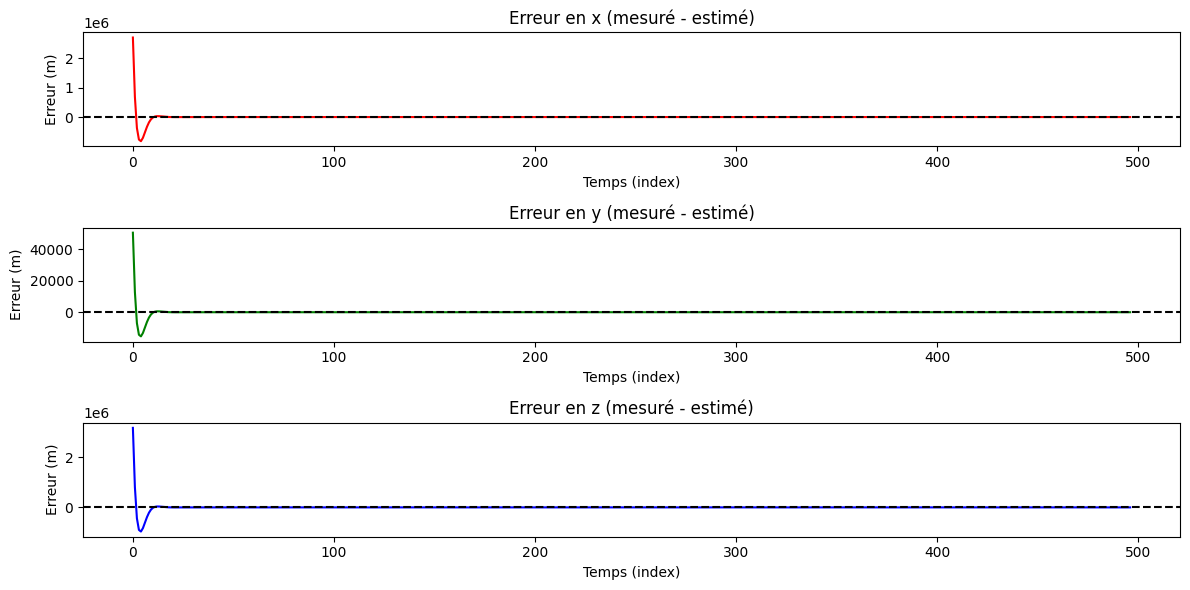

In [140]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Calcul des erreurs entre mesures et estimations (filtrées)
datas['error_x'] = datas['x'] - datas['x_kf']
datas['error_y'] = datas['y'] - datas['y_kf']
datas['error_z'] = datas['z'] - datas['z_kf']

# Calcul des statistiques pour l'erreur
error_x_mean = np.mean(datas['error_x'])
error_y_mean = np.mean(datas['error_y'])
error_z_mean = np.mean(datas['error_z'])

error_x_std = np.std(datas['error_x'])
error_y_std = np.std(datas['error_y'])
error_z_std = np.std(datas['error_z'])

# Affichage des résultats statistiques
print(f"Erreur moyenne en x : {error_x_mean:.3f} m")
print(f"Erreur moyenne en y : {error_y_mean:.3f} m")
print(f"Erreur moyenne en z : {error_z_mean:.3f} m")

print(f"Écart-type de l'erreur en x : {error_x_std:.3f} m")
print(f"Écart-type de l'erreur en y : {error_y_std:.3f} m")
print(f"Écart-type de l'erreur en z : {error_z_std:.3f} m")

# Calcul de la corrélation entre les valeurs mesurées et estimées
corr_x = np.corrcoef(datas['x'], datas['x_kf'])[0, 1]
corr_y = np.corrcoef(datas['y'], datas['y_kf'])[0, 1]
corr_z = np.corrcoef(datas['z'], datas['z_kf'])[0, 1]

print(f"Corrélation entre x et x_kf : {corr_x:.3f}")
print(f"Corrélation entre y et y_kf : {corr_y:.3f}")
print(f"Corrélation entre z et z_kf : {corr_z:.3f}")

# Visualisation des erreurs en x, y et z
plt.figure(figsize=(12, 6))

# Erreurs en x, y et z
plt.subplot(3, 1, 1)
plt.plot(datas['error_x'], label='Erreur en x', color='r')
plt.axhline(0, color='black', linestyle='--')
plt.title('Erreur en x (mesuré - estimé)')
plt.xlabel('Temps (index)')
plt.ylabel('Erreur (m)')

plt.subplot(3, 1, 2)
plt.plot(datas['error_y'], label='Erreur en y', color='g')
plt.axhline(0, color='black', linestyle='--')
plt.title('Erreur en y (mesuré - estimé)')
plt.xlabel('Temps (index)')
plt.ylabel('Erreur (m)')

plt.subplot(3, 1, 3)
plt.plot(datas['error_z'], label='Erreur en z', color='b')
plt.axhline(0, color='black', linestyle='--')
plt.title('Erreur en z (mesuré - estimé)')
plt.xlabel('Temps (index)')
plt.ylabel('Erreur (m)')

plt.tight_layout()
plt.show()
